1. Exploratory Data Analysis:
Getting insight into the dataset is one of the most important things. First step should be to look at the properties of data which gives us clarity. It can give us a meaningful understanding and relationship of data with the target.

2. Data Processing:
Data Cleaning: Dealing with missing value, and Feature Engineering by Creating new features and Enconding. Finally to build Data processing pipeline in this step.

3. Modeling:
The third step is to properly train a model which does not overfit on the seen data. Used cross validation on 10 folds to meausure the performance on train data.

4. Hypter parameter tunning:
Tuning algorithm and model parameters contribute to significant improvement in the score. 

5. Ensembling:
The last step is all about creating a strong model from a large number of weak models. 

In [1]:

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv("test.csv")
train_data.head()

train_copy = train_data.copy()
test_copy = test_data.copy()

# Exploratory Data Analysis

pandas.plotting generate a fast and convenient report with visualization, correalation, missing values.
Oberseve each attribute for the following feature engineering work

*Training set have missing values in Age, Cabin and Embarked columns.

*Test set have missing values in Age, Cabin and Fare columns

In [ ]:
profile = pp.ProfileReport(train_data)
profile.to_file("output.html")

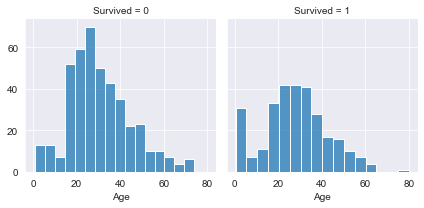

In [26]:
#Age distribution seems to be a gaussian distribution. We can notice that Age distribution are not the same in the survived and not survived subpopulation: 
#Those who are between 60 and 80 are less likely to survive, and childrens and young passengers have higher chances of survival.
#Transforming the age feature into categories seems better than using the age of each person because some there is some age categories that have high or less chance of surviving.
g = sns.FacetGrid(train_copy, col='Survived')
g = g.map(sns.histplot, "Age")

Only 1 value of Fare attribute is missing in test and only 2 values of Embarked attribute are missing in train

In [28]:
test_copy[test_copy['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Fare distribution is very skewed and might result in badbehaviour in our model. Transforming it into log seems like a good solution.

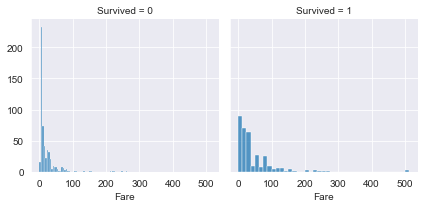

In [30]:
g = sns.FacetGrid(train_copy, col='Survived')
g = g.map(sns.histplot, "Fare")

For the name attribute we can extract the title and analyse it better. 
We can extract family names also but that would take too much time so I am gonna stick to the title only

In [23]:
#Its true that most of Cabin attribute are missing values but we can't drop this feature because some of the cabins have more survival rate than others, 
#for example these who are close to surface.
#It seems like the first letter of the Cabin values are the decks in which the cabins are located. So we will change the cabin attribute with a deck attribute and explore further this new feature

train_data["deck"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train_data['Cabin'] ])
test_data["deck"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test_data['Cabin'] ])

train_data.groupby(['deck','Pclass'])['deck'].count()

deck  Pclass
A     1          15
B     1          47
C     1          59
D     1          29
      2           4
E     1          25
      2           4
      3           3
F     2           8
      3           5
G     3           4
T     1           1
X     1          40
      2         168
      3         479
Name: deck, dtype: int64

In [32]:
train_copy['Title'] = train_copy['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [19]:
def corr(x):
    corr_matrix = x.corr()
    c= corr_matrix["Survived"].sort_values(ascending=False)
    print(c)
corr(train_copy)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


# Data Processing 

Dealing with Missing Data: 
Age > replace the missing values with the media age for each class, for both male and female passengers.

Fare > we have only 1 missing value. We will fill it with the median 3rd class passangers that have no family with them

Embarked > we will use the most Frequent which is S

Cabin > we will deal with it in the feature engineering section because we are going to create a new attribute


In [3]:
class Imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.med_fare_ = X.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
        self.most_freq_embarked = X.Embarked.value_counts().index[0]
        return self
    def transform(self, X, y=None):
        #replacing missing values of Age with median Age for each class. 1 value for each Sex.
        X.Age = X.groupby(['Sex', 'Pclass'])['Age'].apply(lambda z: z.fillna(z.median()))
        # 1 only missing value for Fare. A Man in the third class with no family
        X.Fare = X.Fare.fillna(self.med_fare_)
        # filling Embarked with the most frequent 
        X.Embarked = X.Embarked.fillna(self.most_freq_embarked)
        
        return X
        

Creating new features
In this section we will transform existing attribute and create new ones:

Parch and SibSp > combine to create a Relative on board feature.
Using the Relative On board feature we will create a family attribute which consists of:
(Alone if the passenger has no relatives on board
Small if he have 1 or 2 family members on board
Medium if he have 3, 4 or 5 family members
Large if he has more than 6)

Cabin > we will create a deack attribute by extracting the first letter of the cabin name for each passenger.

Age > transform from continuous data into and attribute with 8 categories.

Fare > Applying log will reduce skewness distribution

Ticket ID > replaced by ticket frequency

Title > extracted from Name and create IsMarried Attribute

In [20]:
class feature_engineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # combining Sibsp and Parch to create relative on board then creating the family attribute
        X["RelativesOnboard"] = X["SibSp"] + X["Parch"]
        X['Family'] = X['RelativesOnboard'].map({0: 'Alone', 1: 'Small', 2: 'Small', 3: 'Medium', 4: 'Medium', 5: 'Medium', 6: 'Large', 7: 'Large', 10: 'Large'})
        # extracting the first letter of each cabin to create deck attribute
        X["Deck"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in X['Cabin'] ])  
        # regrouping deck catergories
        X['Deck'] = X['Deck'].replace(['T', 'A', 'B', 'C'], 'ABC')
        X['Deck'] = X['Deck'].replace(['D', 'E'], 'DE')
        X['Deck'] = X['Deck'].replace(['F', 'G'], 'FG')
        # we will transform the Age from continuous data into and attribute with 14 category.
        X["Age"] = pd.cut(X["Age"],
                               bins=[0., 5.0, 15.0, 25.0, 30.0, 40.0,50.0,60.0, np.inf],
                               labels=[1, 2, 3, 4, 5,6,7,8])
        # For Fare, Applying will reduce skewness distribution
        X["Fare"] = X["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
        # Replace ticket ID by ticket frequency
        X['Ticket_Frequency'] = X.groupby('Ticket')['Ticket'].transform('count')
        # Extract title attribute from Name and create IsMarried Attribute
        X['Title'] = X['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X['Is_Married'] = 0
        X['Is_Married'].loc[X['Title'] == 'Mrs'] = 1
        X['Title'] = X['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
        X['Title'] = X['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
        return X

Label encodeing on the following features:

Age, Fare, Embarked, Sex, Title, Family, Title, RelativesOnboard, Deck.

And use OneHotEncoding on the folliwing featues:

Pclass, Sex, Deck, Family, Title, Embarked

In [21]:
class encoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #label encoding
        for i in ['Age', 'Fare', 'Embarked', 'Sex', 'Title', 'Family', 'Title', 'RelativesOnboard', 'Deck']:
            X[i] = self.le.fit_transform(X[i])
        #OneHotEncoding
        encoded_features = []
        for cat in ['Deck', 'Age','Pclass', 'Sex', 'Title','Embarked','Family','RelativesOnboard']:
            encoded_feat = self.ohe.fit_transform(X[cat].values.reshape(-1, 1)).toarray()
            n = X[cat].nunique()
            cols = ['{}_{}'.format(cat, n) for n in range(1, n + 1)]
            encoded_df = pd.DataFrame(encoded_feat, columns=cols)
            encoded_df.index = X.index
            encoded_features.append(encoded_df)
        X = pd.concat([X, *encoded_features[:8]], axis=1)
        return X

In [22]:
# This class is used after cleaning and feature engineering to drop unnecessary columns
class Columns_drop(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.attribute_names, axis=1)
    

In [23]:
dropped_columns = [ 'RelativesOnboard','Age', 'Sex','Deck', 'Family', 
                   'Embarked', 'PassengerId', 'Pclass', 'Name', 'Ticket','Cabin','Embarked']

In [24]:
processing_pipeline = Pipeline([
    ('Filling missing values', Imputer()),
    ('Feature Engineering', feature_engineering()),
    ('Encoding', encoding()),
    ('dropping useless columns', Columns_drop(dropped_columns) ),
    
])

In [25]:
X_train= train_data.copy()
X_test = test_data.copy()

X_train = processing_pipeline.fit_transform(X_train)
corr(X_train)
X_train = X_train.drop('Survived',axis=1 )
y_train = train_data['Survived']
X_test = processing_pipeline.fit_transform(X_test)


Survived              1.000000
Sex_1                 0.543351
Title_3               0.540769
Is_Married            0.339040
Fare                  0.333943
Pclass_1              0.285904
Family_4              0.238059
Deck_2                0.213430
Deck_1                0.202551
Embarked_1            0.168240
RelativesOnboard_2    0.163157
Age_1                 0.150304
RelativesOnboard_3    0.143869
RelativesOnboard_4    0.128347
Pclass_2              0.093349
Title_2               0.085221
Parch                 0.081629
Age_5                 0.068219
Deck_3                0.058617
Ticket_Frequency      0.038247
Age_2                 0.034183
Family_3              0.014687
Age_7                 0.009569
Embarked_2            0.003650
Age_4                 0.002193
Age_6                -0.000079
RelativesOnboard_7   -0.012134
Title_1              -0.031348
SibSp                -0.035322
RelativesOnboard_5   -0.049466
Age_8                -0.051224
RelativesOnboard_8   -0.064988
Relative

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_enco

In [26]:
X_train.shape, X_test.shape, y_train.shape

((891, 43), (418, 43), (891,))

#  Modeling

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

Evaluating models and making a choice

In this section we evaluate the performance of some well known models on the data and chose those who have a good accuracy. We will cross validation on 10 folds to meausure the performance on train data.

In [27]:
kfold = StratifiedKFold(n_splits=10)
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier())
classifiers.append(XGBClassifier())
classifiers.append(LGBMClassifier())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"Algorithm":["SVC","DecisionTree","RandomForest","GradientBoosting","ExtraTrees","XGB",'LGBM'],"CrossValMeans":cv_means,"CrossValerrors": cv_std})
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,SVC,0.784677,0.042720
1,DecisionTree,0.813741,0.024778
2,RandomForest,0.817050,0.040450
3,GradientBoosting,0.832842,0.040291
4,ExtraTrees,0.800334,0.039011
5,XGB,0.828348,0.037613
6,LGBM,0.823828,0.039609


Hypter parameter tunning and combining models

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = [ 20 ,'auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
rf_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [52]:
# Random forest Hyper parameter tuning
rf = RandomForestClassifier()

#fitting
Grid_s_rf = GridSearchCV(rf, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = True)
Grid_s_rf.fit(X_train,y_train)
RFC_best = Grid_s_rf.best_estimator_

# Best score
Grid_s_rf.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  7.0min finished


0.8372615039281706

In [51]:
# The number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = [ 20 ,'auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,  10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# The function to measure the quality of a split
# Create the random grid
gb_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}

In [53]:
gbc = GradientBoostingClassifier()

#fitting
Grid_s_gb = GridSearchCV(gbc,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
Grid_s_gb.fit(X_train,y_train)
GBC_best = Grid_s_gb.best_estimator_

# Best score
Grid_s_gb.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 20.0min finished


0.8249158249158249

In [91]:
max_depth = [int(x) for x in np.linspace(5, 20, num = 3)]
min_child_weight = [5,6,7]
eta = [.3, .2, .1, .05, .01, .005]

XGB_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'eta': eta,
               'min_child_weight': min_child_weight,}

In [92]:
XGB = XGBClassifier()

Grid_s_XGB = GridSearchCV(XGB, param_grid = XGB_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = True)
Grid_s_XGB.fit(X_train,y_train)
XGB_best = Grid_s_XGB.best_estimator_

Grid_s_XGB.best_score_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 10.7min finished


0.8406285072951739

In [32]:
#Combining 2 models
votingC = VotingClassifier(estimators=[('lg', lg),('xgb',xgb)], voting='soft', n_jobs=-1)
votingC = votingC.fit(X_train, y_train)
print('Score: ', votingC.score(X_train, y_train))

Score:  0.9214365881032548


In [29]:

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print('Score: ', xgb.score(X_train, y_train))

Score:  0.8799102132435466


In [94]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
rf.fit(X_train,y_train)
print('Score: ', rf.score(X_train, y_train))

Score:  0.8249158249158249


In [34]:
lg = LGBMClassifier()
lg.fit(X_train,y_train)
print('Score: ', lg.score(X_train, y_train))

Score:  0.9427609427609428


In [45]:
predictions = model_2.predict(X_test)
submission = pd.DataFrame({'PassengerId': test_data.PassengerId,
                           'Survived': predictions})
submission.to_csv('submission.csv', index = False)

In [40]:
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25, random_state=0)

In [42]:
model_1 = XGBClassifier(n_estimators = 10000, learning_rate = 0.5, use_label_encoder=False, eval_metric = 'logloss')
model_1.fit(s_X_train, s_y_train, early_stopping_rounds = 9, eval_set = [(s_X_test, s_y_test)], verbose = False)
print('Score: ', model_1.score(X_train, y_train))

Score:  0.8608305274971941


In [44]:
model_2 = RandomForestClassifier(n_estimators = 550, max_depth = 6, random_state = 1)
model_2.fit(s_X_train, s_y_train)
print('Score: ', model_2.score(X_train, y_train))

Score:  0.8473625140291807
